In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


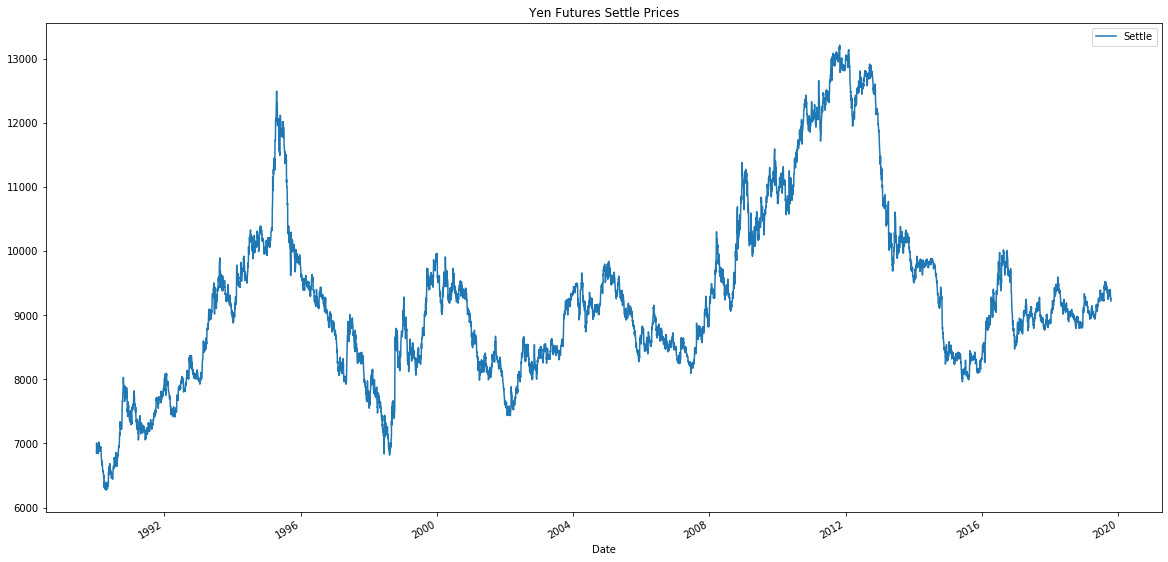

In [5]:
yen_futures.plot(y='Settle', figsize = (20, 10), title="Yen Futures Settle Prices")

In [6]:
import statsmodels.api as sm

In [7]:
yf_noise, yf_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

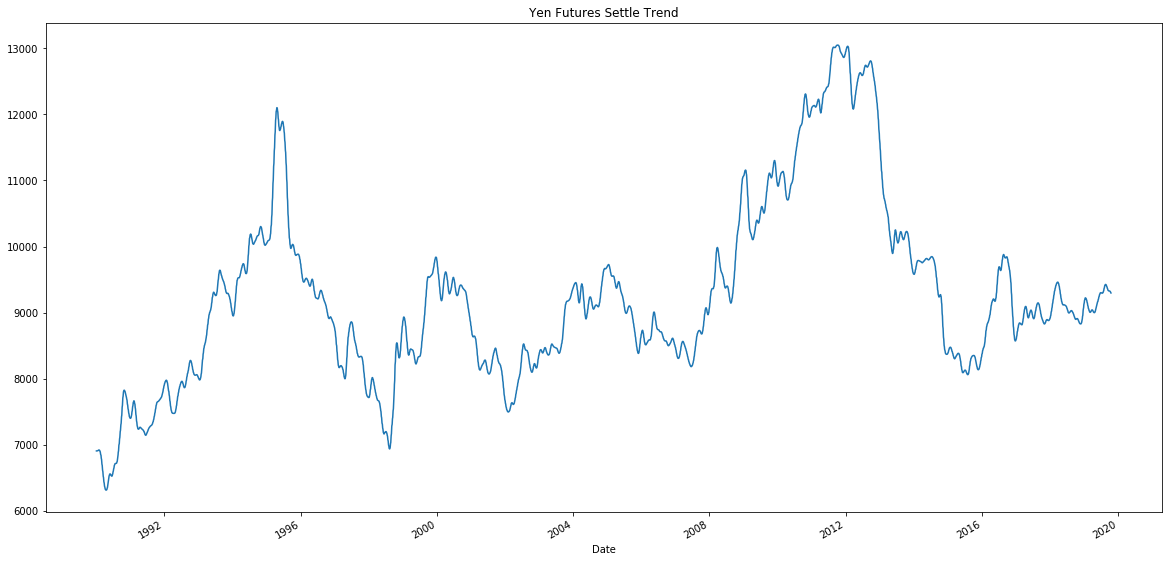

In [9]:
yf_trend.plot(figsize=(20, 10), title="Yen Futures Settle Trend")

In [10]:
columns = ['Open', 'High', 'Low', 'Last', 'Change', 'Volume', 'Previous Day Open Interest']

In [11]:
yen_futures.drop(columns, inplace=True, axis=1)

In [12]:
yen_futures.head()

,Settle
Date,
1990-01-02,6847.0
1990-01-03,6887.0
1990-01-04,7008.0
1990-01-05,6950.0
1990-01-08,6959.0


In [13]:
yen_df = pd.concat([yen_futures, yf_noise, yf_trend], axis="columns", join="inner")
yen_df.columns = ['Settle', 'Noise', 'Trend']
yen_df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


/Users/killermac/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


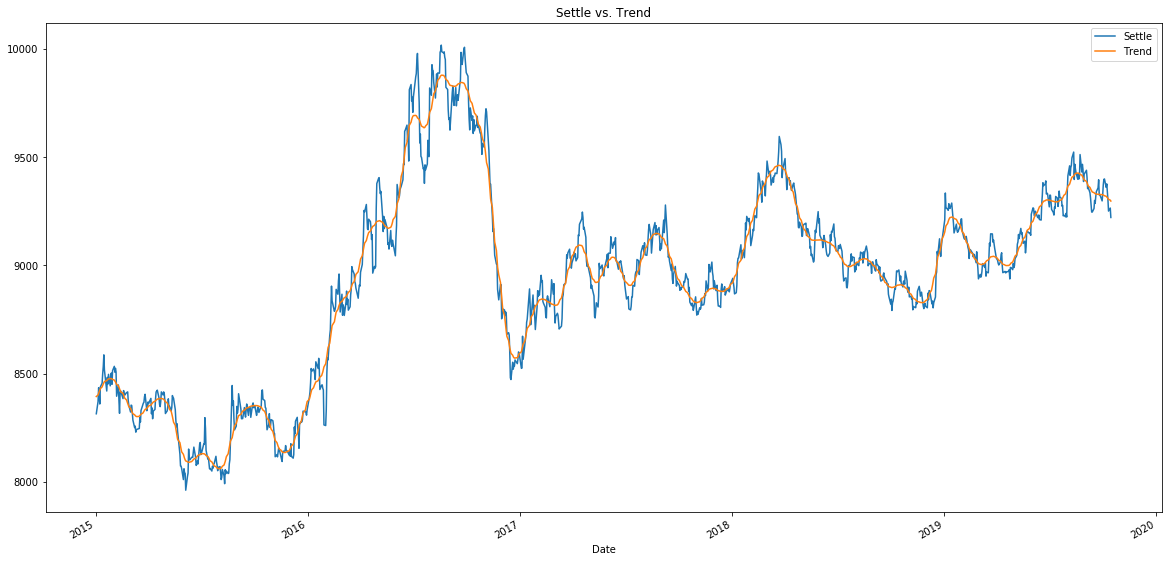

In [14]:
time_period_df = yen_df.loc["2015-01-01":]
col2 = ['Noise']
time_period_df.drop(col2, inplace=True, axis=1)
time_period_df.plot(figsize=(20, 10), title="Settle vs. Trend")

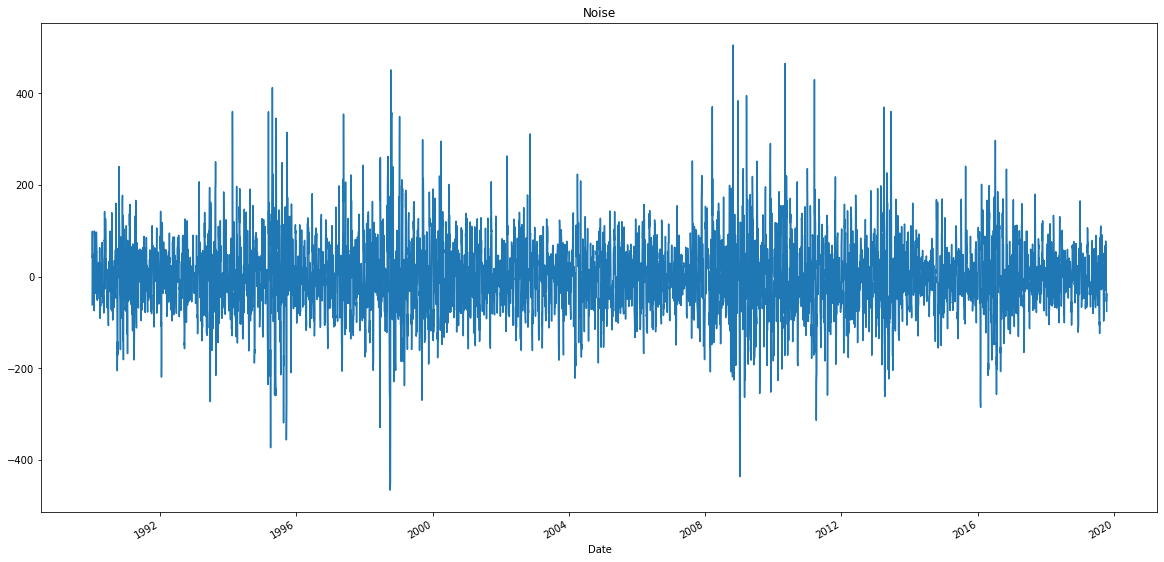

In [15]:
yf_noise.plot(figsize=(20, 10), title="Noise")

In [16]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [17]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

In [18]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

In [19]:
# Fit the model and assign it to a variable called results
results = model.fit()

In [20]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 31 Aug 2020   AIC                          15798.142
Time:                        19:48:12   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.278      0.231      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.1918           +0.0000j          157.1918            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

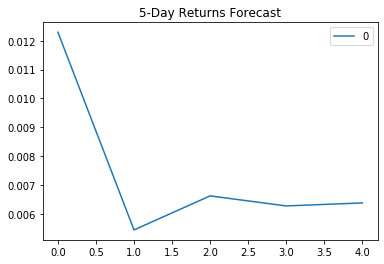

In [21]:
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5-Day Returns Forecast")

In [22]:
yen_arima = pd.DataFrame(yen_futures["Settle"])
yen_arima.index = pd.DatetimeIndex(yen_arima.index).to_period('M')

In [23]:
arima_model = ARIMA(yen_arima["Settle"], order=(5, 1, 1))

In [24]:
arima_results = arima_model.fit()

In [25]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Mon, 31 Aug 2020   AIC                          83905.238
Time:                        19:48:16   BIC                          83960.635
Sample:                    01-31-1990   HQIC                         83924.259
                         - 10-31-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2823      0.699      0.404      0.686      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3786j            2.3409           -0.1002
AR.2            1.8920           +1.3786j            2.3409            0.1002
AR.3           -2.2711           -3.0199j            3.7785           -0.3526
AR.4           -2.2711           +3.0199j            3.7785            0.3526
AR.5          -11.1033           -0.0000j           11.1033           -0.5000
MA.1            3.3632           +0.0000j            3.3632            0.0000
-----------------------------------------------------------------------------
"""

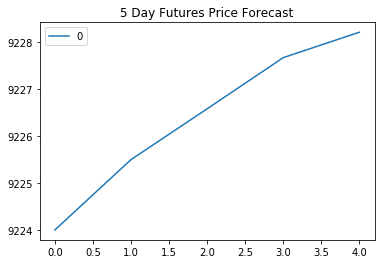

In [26]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

In [27]:
import arch as arch
from arch import arch_model

In [28]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

In [29]:
# Fit the model
garch_results = garch_model.fit(disp="off")

In [30]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Aug 31 2020   Df Residuals:                     7510
Time:                        19:48:17   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [31]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [32]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [33]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [34]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


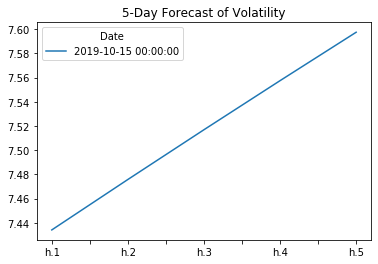

In [35]:
# Plot the final forecast
final.plot(title="5-Day Forecast of Volatility")